# Machine Learning Modeling
## Synthetic failures

In [1]:
import pandas as pd
from pandas.api.types import is_string_dtype
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import joblib

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBRFClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(20, 10)}, font_scale = 1.5)

import warnings
warnings.simplefilter("ignore")

In [2]:
sim_results = pd.read_csv('../outputs/synthetic_failure_data.csv', index_col=0)

In [3]:
sim_results.describe()

,P_Z0_before,P_Z0_after,P_Z1_before,P_Z1_after,P_WH_before,P_WH_after,T_Z0_before,T_Z0_after,T_Z1_before,T_Z1_after,P_bottom_before,P_bottom_after,T_WH_before,T_WH_after
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,795.780904,795.903765,735.939978,735.938359,214.864341,214.892025,87.652712,87.638564,88.019898,88.038892,774.165725,774.139282,70.147493,70.149180
std,58.817796,58.852799,58.832469,58.847604,56.420628,56.441279,2.603856,2.625282,2.095212,2.094191,62.803097,62.724906,10.946948,10.985431
min,394.991801,397.564330,338.433137,336.538581,71.859497,70.813158,67.070763,66.035521,70.533726,69.467597,386.387190,377.313000,-19.457644,-19.537010
25%,782.566103,782.715170,722.705939,722.449687,208.660479,208.370108,86.680089,86.661342,87.065788,87.122643,745.772686,746.299475,69.136597,69.216885
50%,791.052767,791.176237,731.129291,731.393215,224.555067,224.585509,88.001069,88.013170,88.274961,88.311841,785.308885,785.329936,71.483232,71.500504
75%,833.105792,833.113459,773.414780,773.222119,228.189981,228.294244,89.195174,89.160705,89.352212,89.324018,801.360093,800.880479,73.734047,73.691120
max,864.287158,862.217479,804.292568,803.229866,445.717953,444.195905,93.888568,94.806261,93.424666,94.054570,858.963293,860.529145,86.400667,86.773722


In [4]:
sim_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   P_Z0_before               10000 non-null  float64
 1   P_Z0_after                10000 non-null  float64
 2   P_Z1_before               10000 non-null  float64
 3   P_Z1_after                10000 non-null  float64
 4   P_WH_before               10000 non-null  float64
 5   P_WH_after                10000 non-null  float64
 6   T_Z0_before               10000 non-null  float64
 7   T_Z0_after                10000 non-null  float64
 8   T_Z1_before               10000 non-null  float64
 9   T_Z1_after                10000 non-null  float64
 10  top_icv_status_before     10000 non-null  bool   
 11  top_icv_status_after      10000 non-null  bool   
 12  bottom_icv_status_before  10000 non-null  bool   
 13  bottom_icv_status_after   10000 non-null  bool   
 14  P_botto

In [5]:
sim_results['command_type'].value_counts()

No-action       2514
Open_Bottom     1902
Close_Bottom    1887
Close_Top       1849
Open_Top        1848
Name: command_type, dtype: int64

In [6]:
# sim_results['delta'] = sim_results['P_bottom'].diff()
# sim_results = sim_results.iloc[lambda x: x.index % 2 == 1]
# sim_results

In [7]:
sim_results.rename(columns={'failure': 'action_result'}, inplace=True)
sim_results['action_result'] = sim_results['action_result'].apply(lambda x: 'Failure' if x else 'Normal')
sim_results

,P_Z0_before,P_Z0_after,P_Z1_before,P_Z1_after,P_WH_before,P_WH_after,T_Z0_before,T_Z0_after,T_Z1_before,T_Z1_after,top_icv_status_before,top_icv_status_after,bottom_icv_status_before,bottom_icv_status_after,P_bottom_before,P_bottom_after,T_WH_before,T_WH_after,command_type,action_result
0,782.991774,781.513238,721.997335,732.645404,228.072793,222.739237,88.990443,88.017064,88.256267,91.844784,True,True,True,False,784.543408,714.596127,71.206940,72.954653,Close_Bottom,Failure
1,823.407968,836.298427,785.214298,786.737540,114.380874,109.468553,85.859813,88.941707,90.356803,87.281548,True,True,False,True,733.144915,834.406636,82.471340,82.429775,Open_Bottom,Normal
2,783.162356,781.606394,727.905276,727.690796,224.554990,230.421390,89.138396,88.773388,89.711909,88.672596,True,True,True,True,786.286632,785.434586,72.559822,71.329930,No-action,Normal
3,782.434641,799.091495,725.812266,725.502688,217.380665,222.701668,88.840552,89.561738,88.047662,87.951192,True,True,True,False,784.875416,709.494408,71.972874,68.481609,Close_Bottom,Failure
4,845.024456,830.298714,778.727926,791.655508,105.516327,111.314215,85.680819,86.664650,89.330981,86.211135,True,True,False,False,726.617208,737.646014,81.582149,78.978201,No-action,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,787.271113,781.998460,710.195918,716.790706,227.571746,222.070860,88.276114,86.481481,88.353872,88.491776,True,False,True,True,783.550277,738.536140,70.566993,64.813454,Close_Top,Failure
9996,810.406086,794.551916,752.353625,750.208143,228.402031,224.036259,88.164860,87.298385,88.116074,90.366115,False,True,True,True,763.311953,800.419377,68.210562,73.542945,Open_Top,Failure
9997,787.086793,785.018482,732.677958,722.580568,223.745255,226.726036,89.784324,87.503559,89.757217,89.826107,True,True,True,True,790.285841,786.020107,73.289724,71.450532,Close_Bottom,Failure
9998,850.027606,845.226598,774.510375,793.817333,115.348739,110.382150,87.331351,89.311389,84.625393,85.116316,True,True,True,False,840.237675,739.133578,80.092350,78.105941,Close_Bottom,Failure


In [8]:
# Balanced dataset
sim_results.groupby(by='action_result').count()

,P_Z0_before,P_Z0_after,P_Z1_before,P_Z1_after,P_WH_before,P_WH_after,T_Z0_before,T_Z0_after,T_Z1_before,T_Z1_after,top_icv_status_before,top_icv_status_after,bottom_icv_status_before,bottom_icv_status_after,P_bottom_before,P_bottom_after,T_WH_before,T_WH_after,command_type
action_result,,,,,,,,,,,,,,,,,,,
Failure,4952,4952,4952,4952,4952,4952,4952,4952,4952,4952,4952,4952,4952,4952,4952,4952,4952,4952,4952
Normal,5048,5048,5048,5048,5048,5048,5048,5048,5048,5048,5048,5048,5048,5048,5048,5048,5048,5048,5048


## Data engineering
For each measure (float64 variales) we calculated the difference after/before any action and store it in a column of our dataset

In [9]:
float_vars = set([col.split('_')[0]+'_'+col.split('_')[1] for col in list(sim_results.columns) if sim_results[col].dtype == 'float64'])
for name in float_vars:
    cols = [col for col in list(sim_results.columns) if col.startswith(name)]
    sim_results[name+'_delta'] = sim_results[cols[1]] - sim_results[cols[0]]

In [10]:
sim_results

,P_Z0_before,P_Z0_after,P_Z1_before,P_Z1_after,P_WH_before,P_WH_after,T_Z0_before,T_Z0_after,T_Z1_before,T_Z1_after,...,T_WH_after,command_type,action_result,T_Z1_delta,T_Z0_delta,P_Z1_delta,P_Z0_delta,P_WH_delta,P_bottom_delta,T_WH_delta
0,782.991774,781.513238,721.997335,732.645404,228.072793,222.739237,88.990443,88.017064,88.256267,91.844784,...,72.954653,Close_Bottom,Failure,3.588516,-0.973379,10.648068,-1.478536,-5.333556,-69.947280,1.747713
1,823.407968,836.298427,785.214298,786.737540,114.380874,109.468553,85.859813,88.941707,90.356803,87.281548,...,82.429775,Open_Bottom,Normal,-3.075255,3.081894,1.523242,12.890459,-4.912321,101.261721,-0.041565
2,783.162356,781.606394,727.905276,727.690796,224.554990,230.421390,89.138396,88.773388,89.711909,88.672596,...,71.329930,No-action,Normal,-1.039313,-0.365007,-0.214480,-1.555962,5.866400,-0.852047,-1.229892
3,782.434641,799.091495,725.812266,725.502688,217.380665,222.701668,88.840552,89.561738,88.047662,87.951192,...,68.481609,Close_Bottom,Failure,-0.096470,0.721186,-0.309578,16.656854,5.321003,-75.381007,-3.491265
4,845.024456,830.298714,778.727926,791.655508,105.516327,111.314215,85.680819,86.664650,89.330981,86.211135,...,78.978201,No-action,Normal,-3.119846,0.983832,12.927583,-14.725742,5.797888,11.028805,-2.603948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,787.271113,781.998460,710.195918,716.790706,227.571746,222.070860,88.276114,86.481481,88.353872,88.491776,...,64.813454,Close_Top,Failure,0.137904,-1.794632,6.594787,-5.272653,-5.500886,-45.014137,-5.753539
9996,810.406086,794.551916,752.353625,750.208143,228.402031,224.036259,88.164860,87.298385,88.116074,90.366115,...,73.542945,Open_Top,Failure,2.250041,-0.866476,-2.145482,-15.854170,-4.365773,37.107424,5.332383
9997,787.086793,785.018482,732.677958,722.580568,223.745255,226.726036,89.784324,87.503559,89.757217,89.826107,...,71.450532,Close_Bottom,Failure,0.068890,-2.280765,-10.097390,-2.068311,2.980780,-4.265735,-1.839192
9998,850.027606,845.226598,774.510375,793.817333,115.348739,110.382150,87.331351,89.311389,84.625393,85.116316,...,78.105941,Close_Bottom,Failure,0.490923,1.980038,19.306958,-4.801008,-4.966590,-101.104098,-1.986409


In [11]:
sim_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   P_Z0_before               10000 non-null  float64
 1   P_Z0_after                10000 non-null  float64
 2   P_Z1_before               10000 non-null  float64
 3   P_Z1_after                10000 non-null  float64
 4   P_WH_before               10000 non-null  float64
 5   P_WH_after                10000 non-null  float64
 6   T_Z0_before               10000 non-null  float64
 7   T_Z0_after                10000 non-null  float64
 8   T_Z1_before               10000 non-null  float64
 9   T_Z1_after                10000 non-null  float64
 10  top_icv_status_before     10000 non-null  bool   
 11  top_icv_status_after      10000 non-null  bool   
 12  bottom_icv_status_before  10000 non-null  bool   
 13  bottom_icv_status_after   10000 non-null  bool   
 14  P_botto

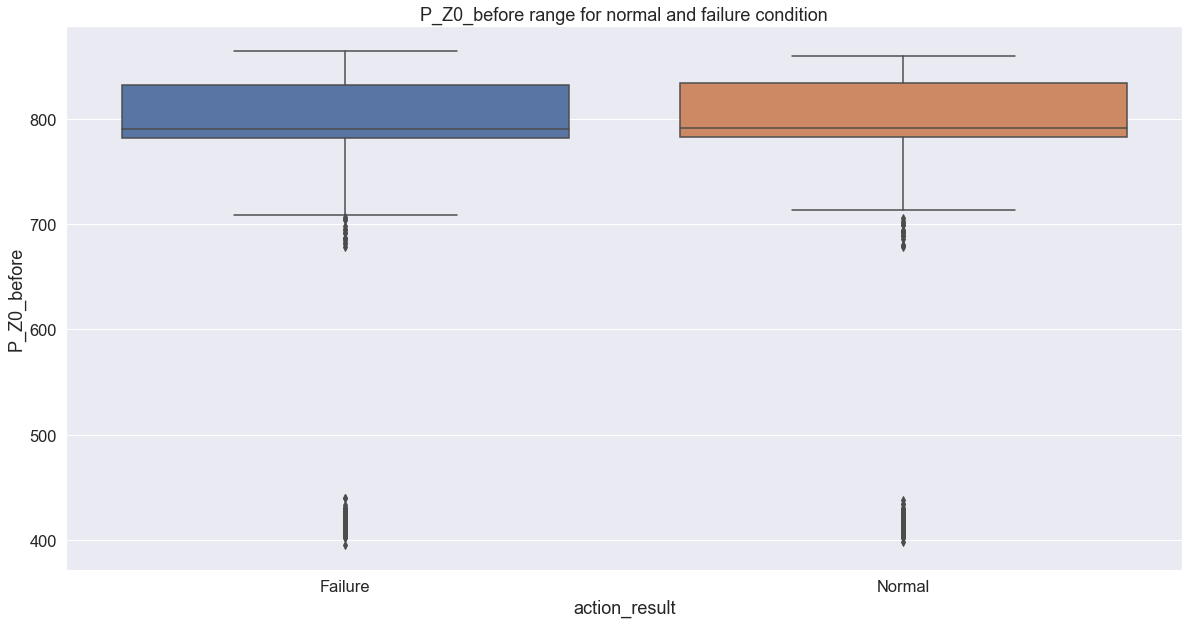

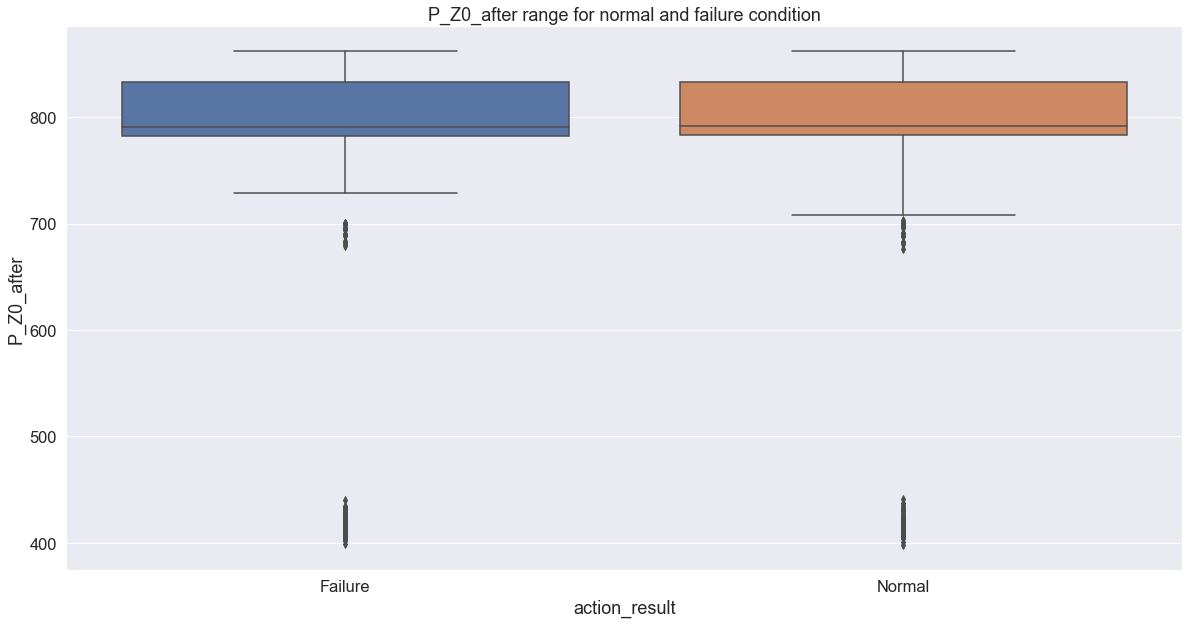

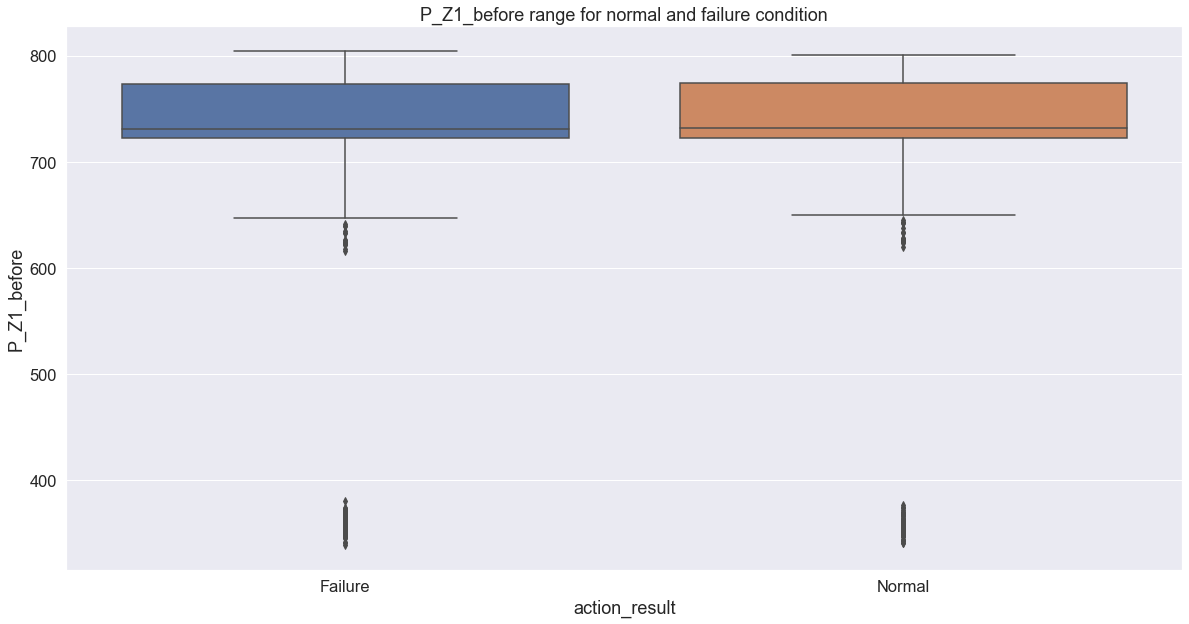

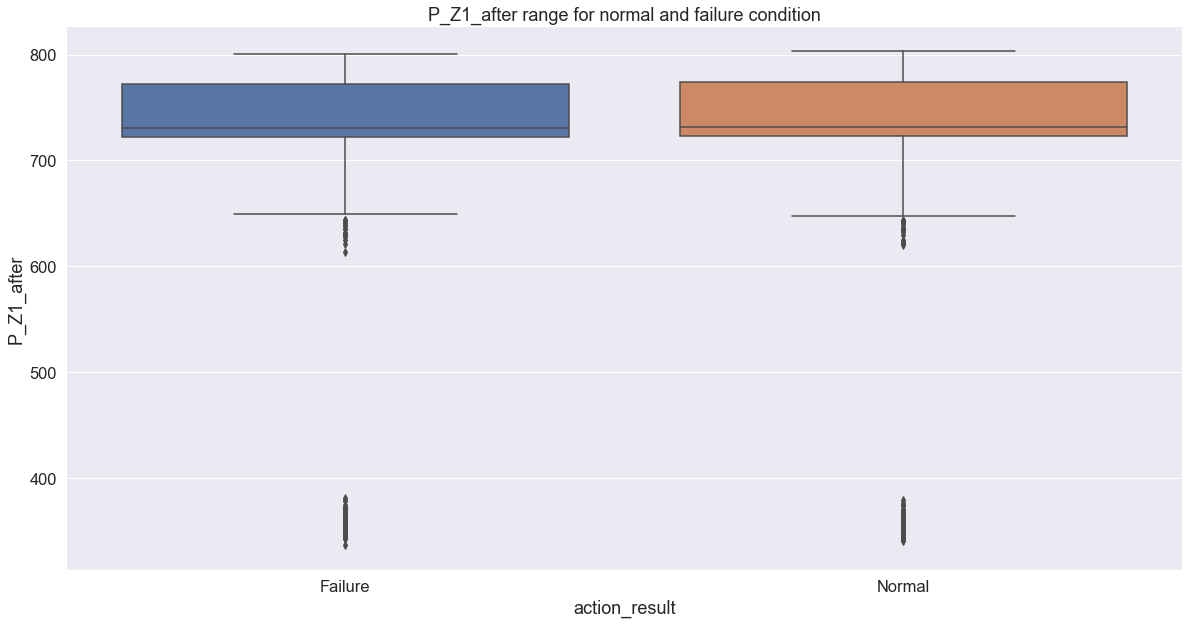

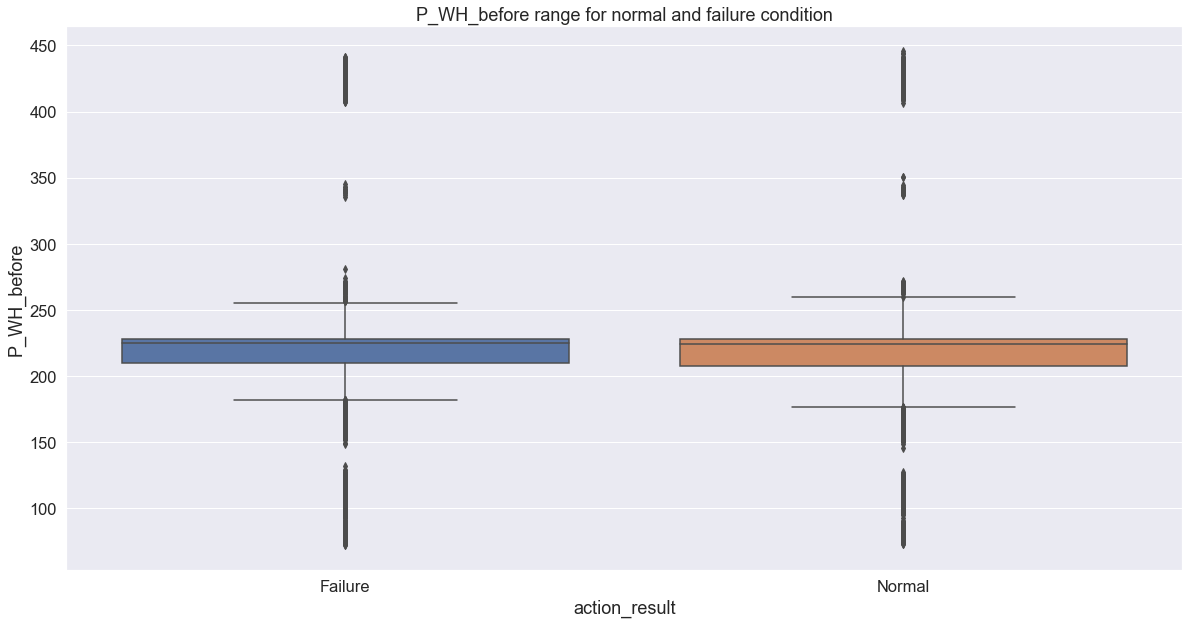

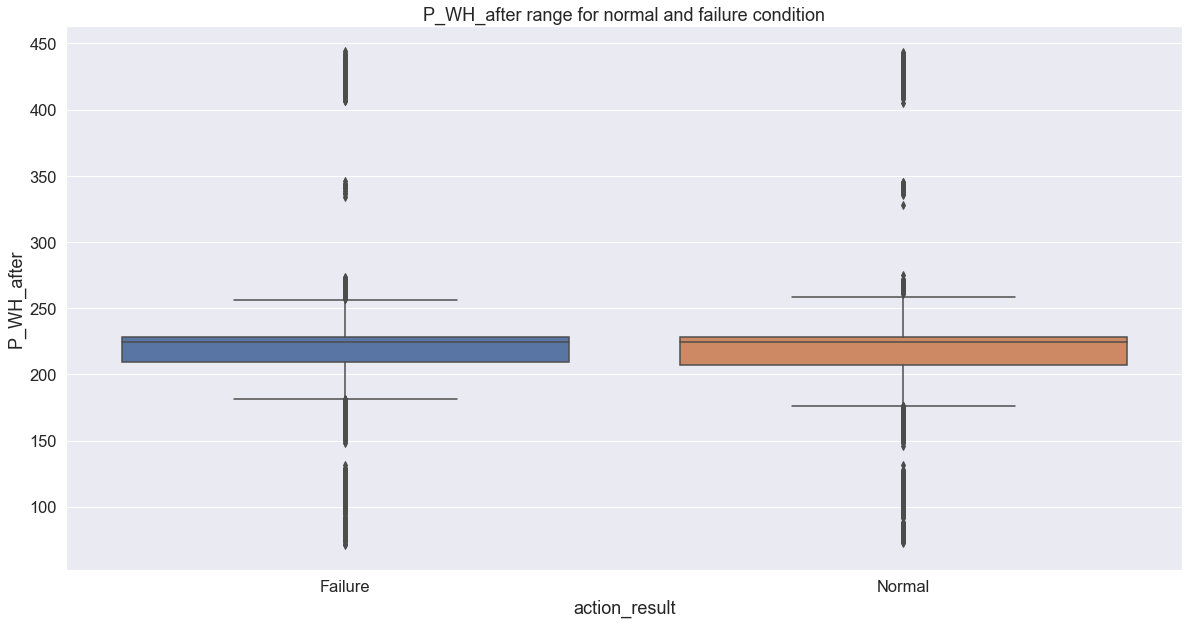

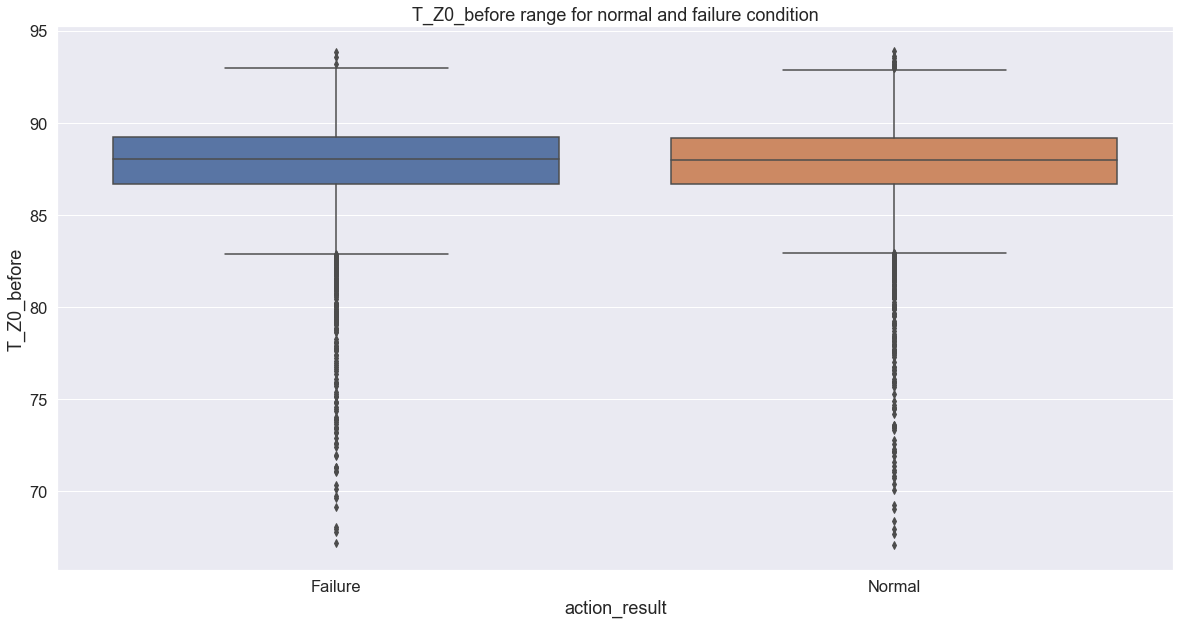

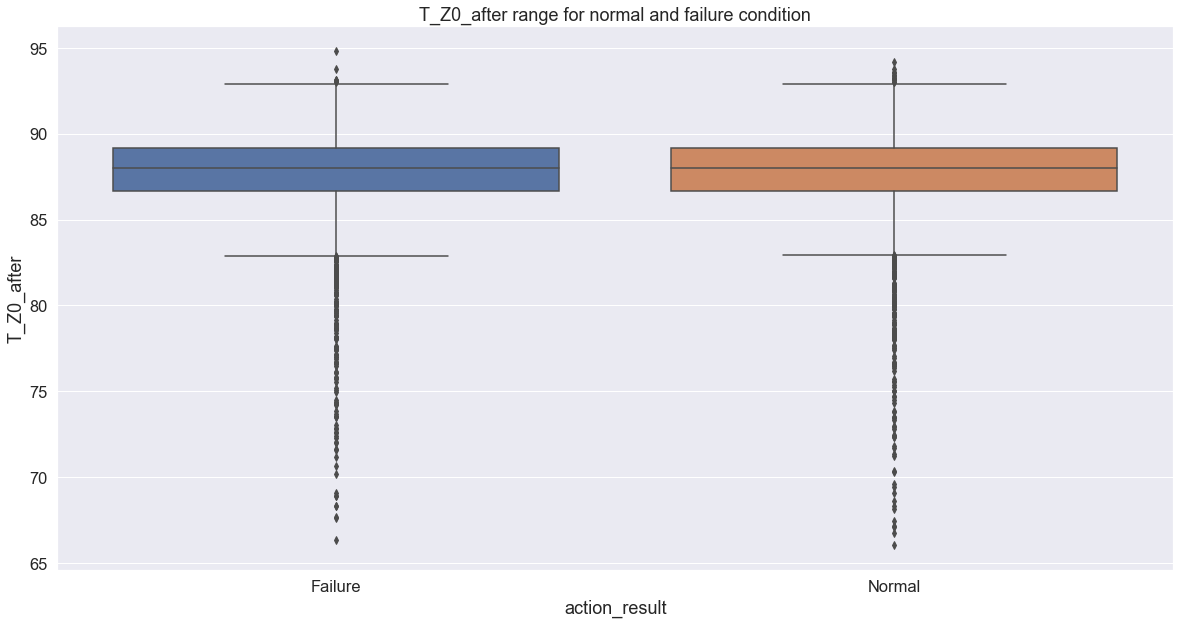

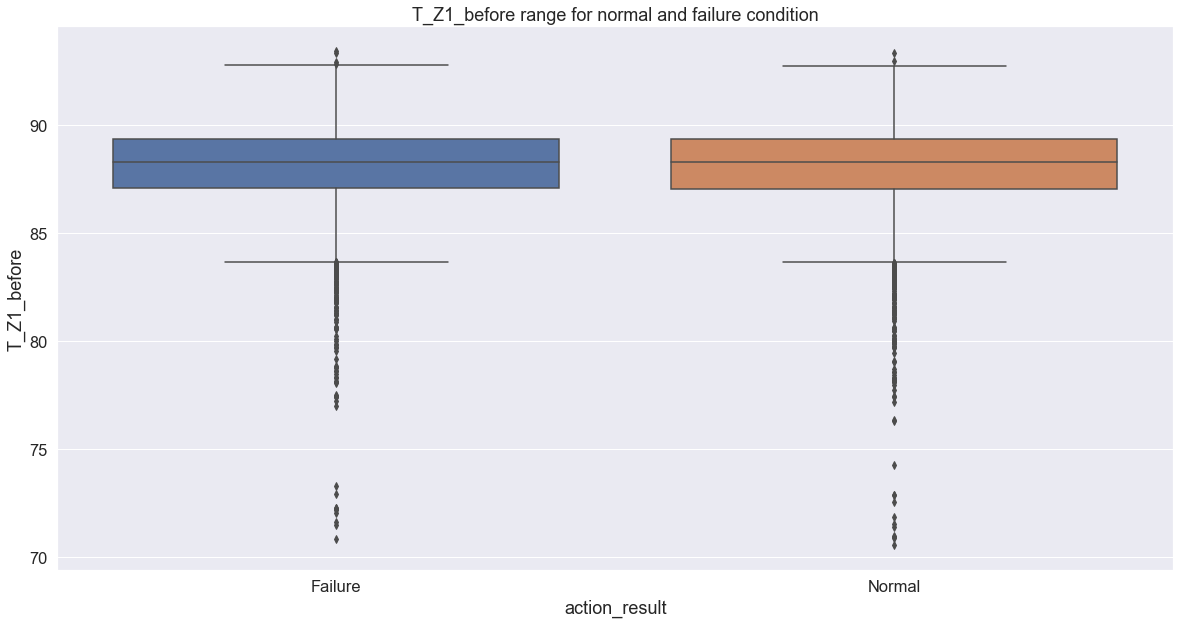

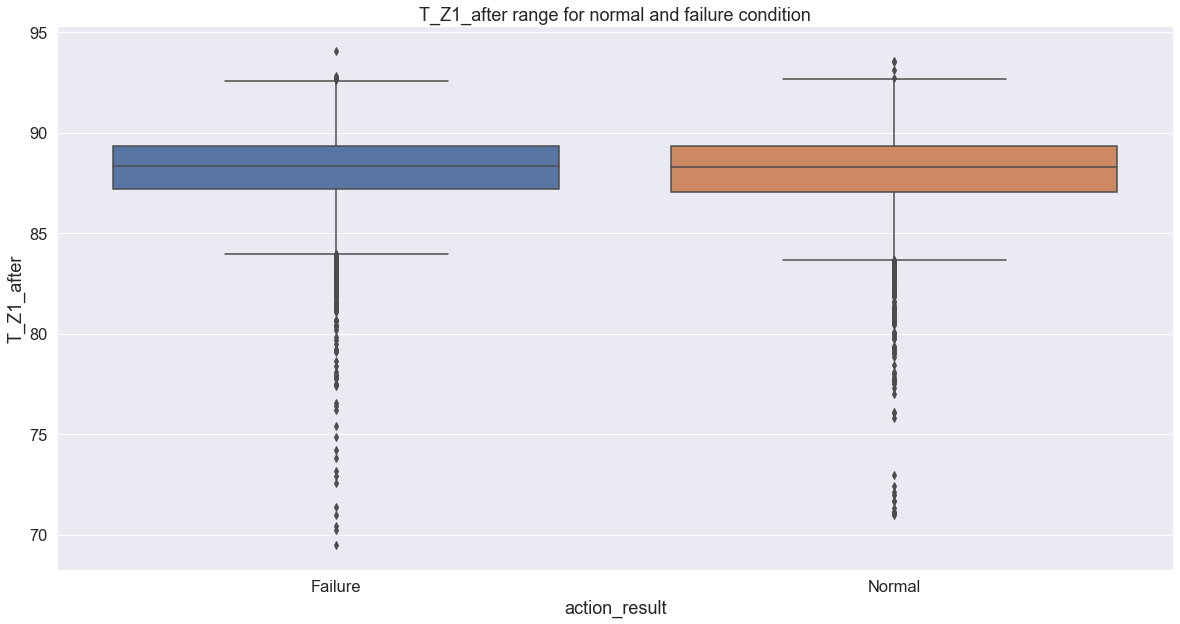

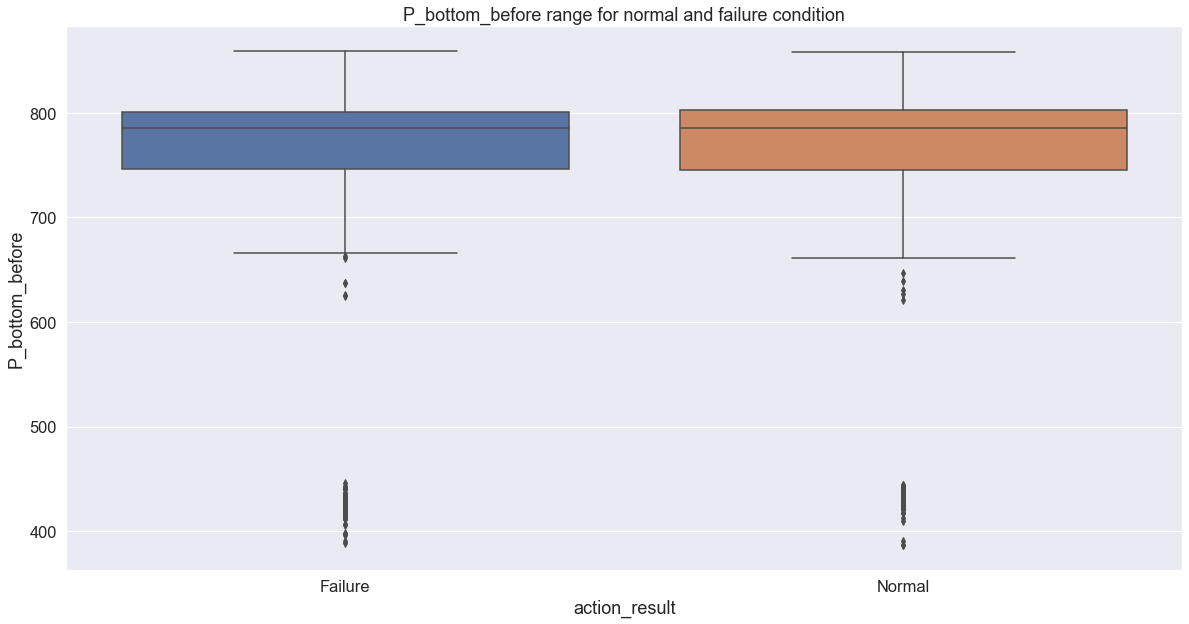

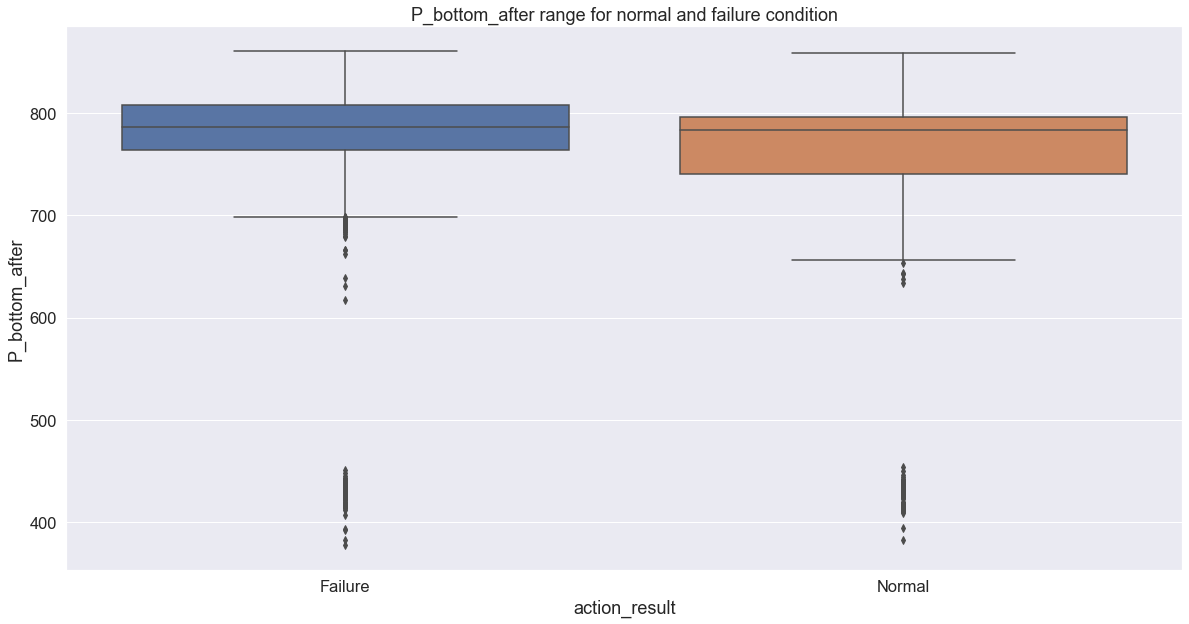

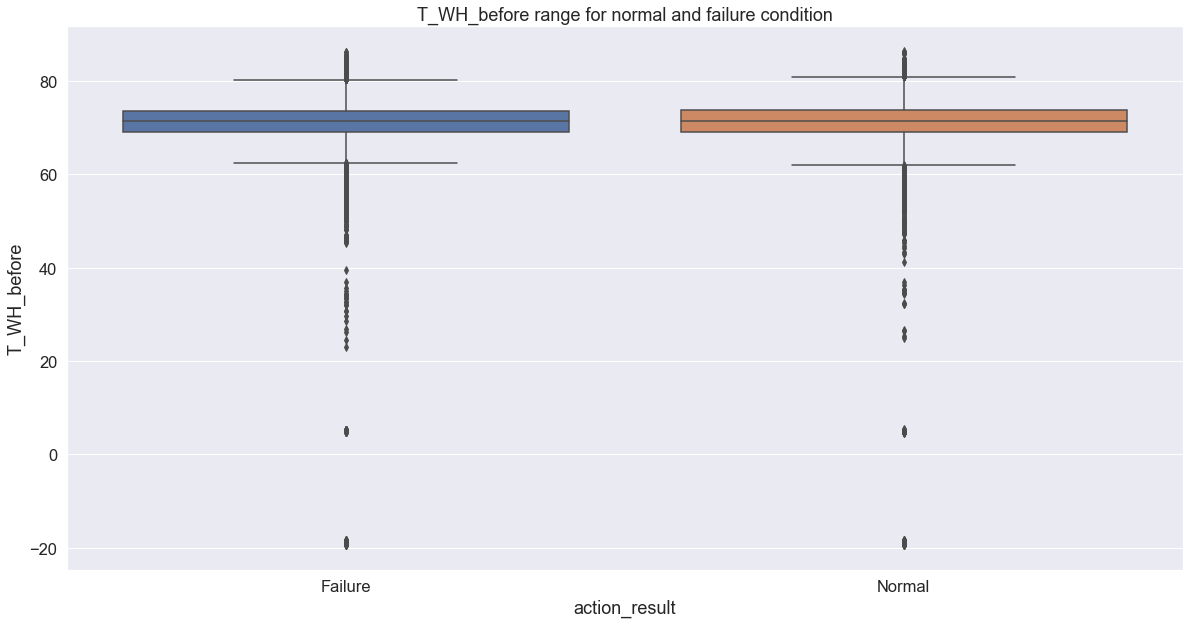

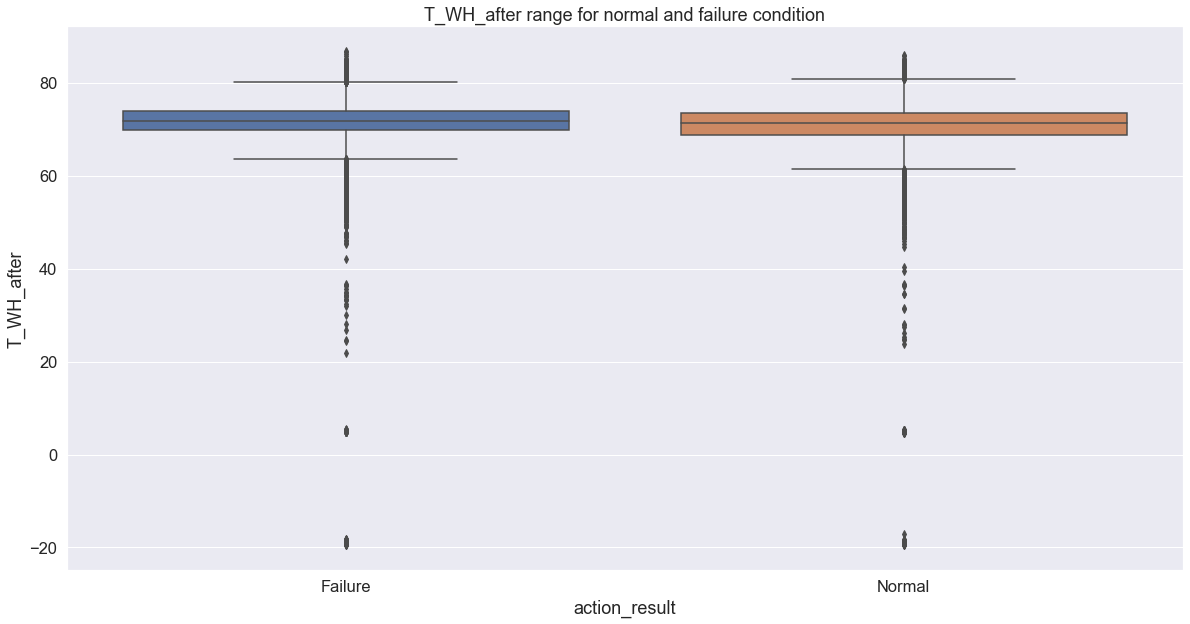

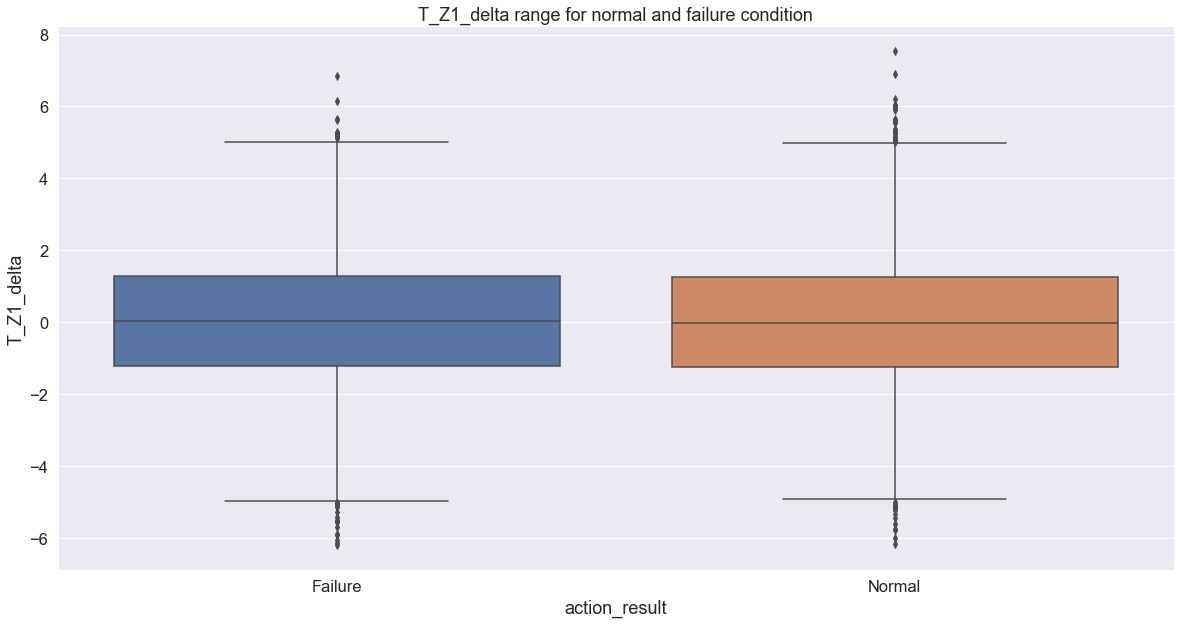

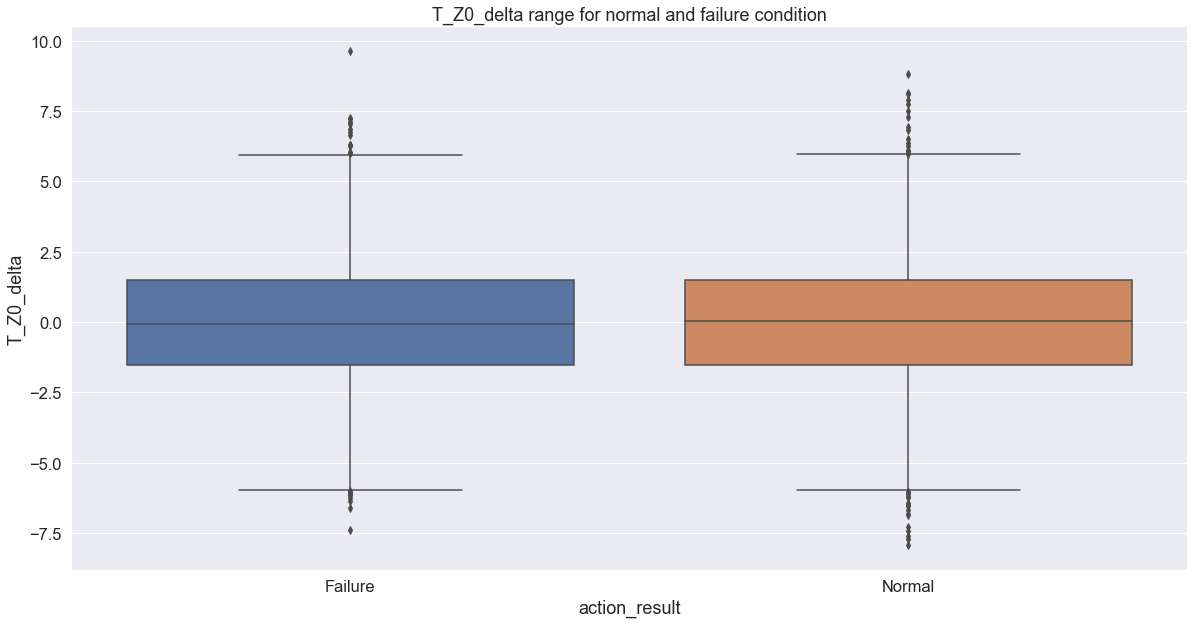

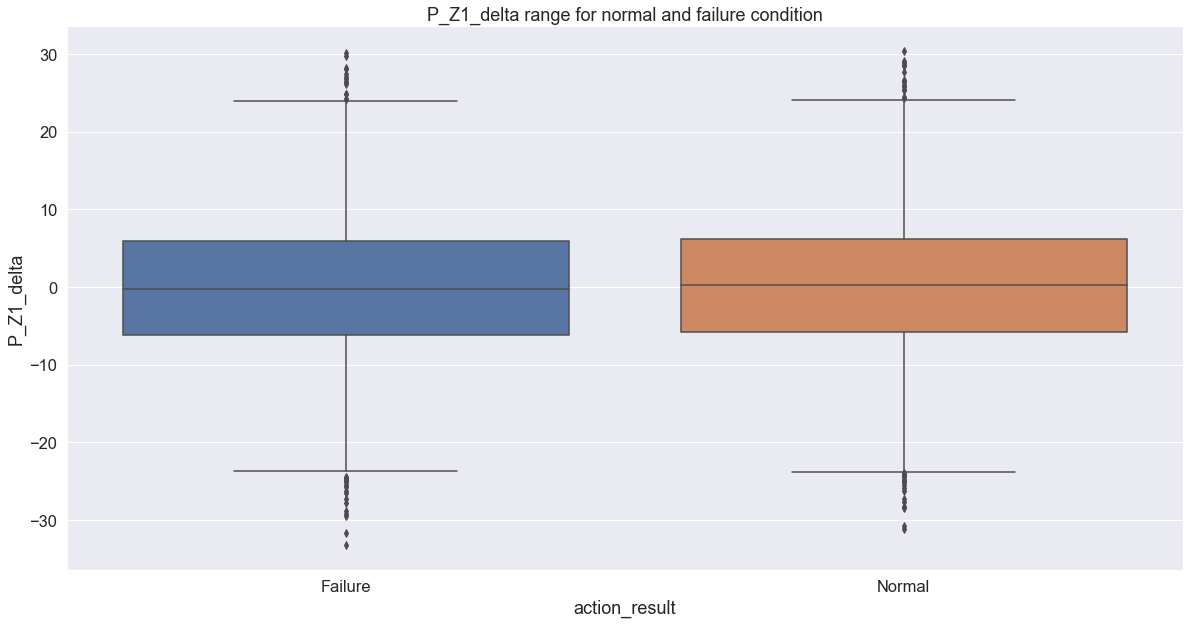

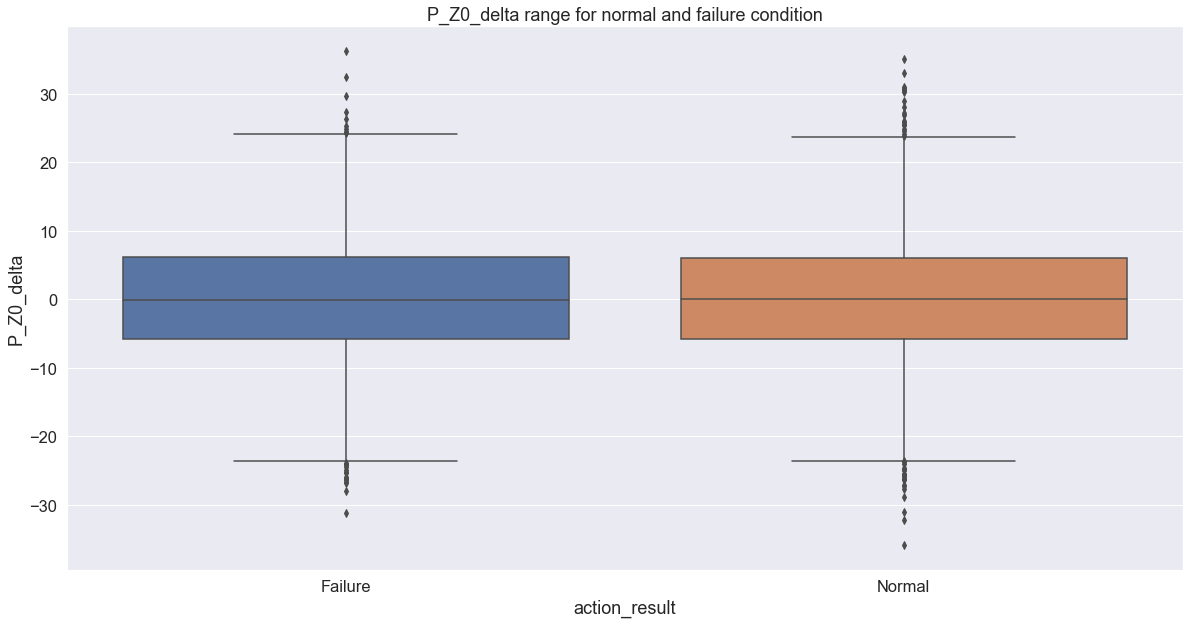

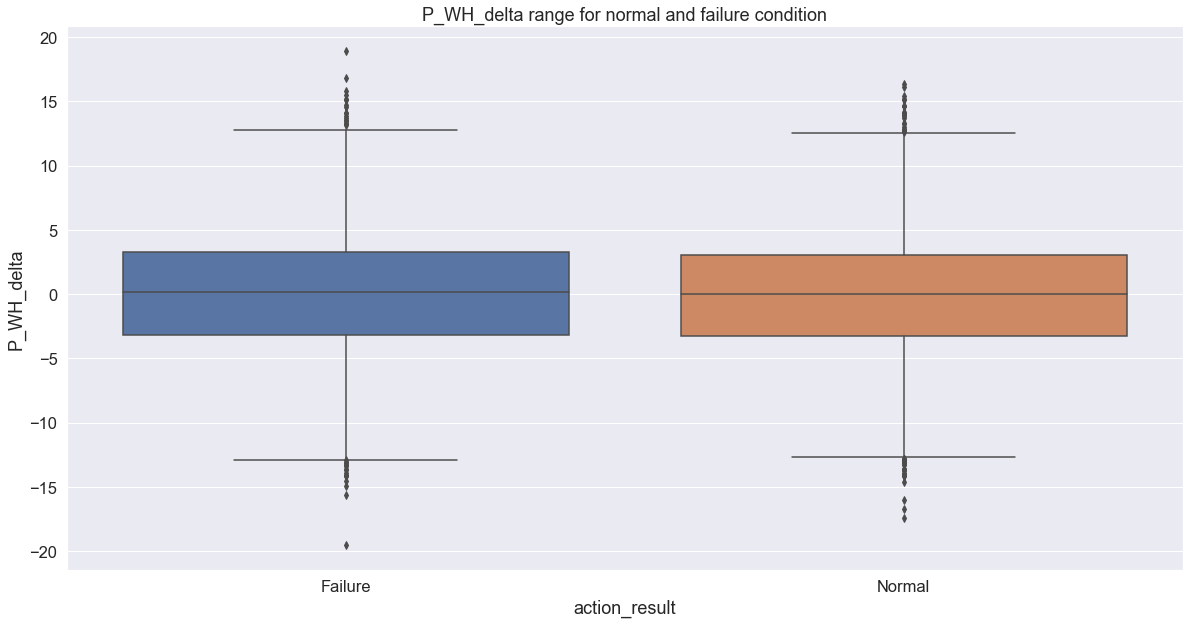

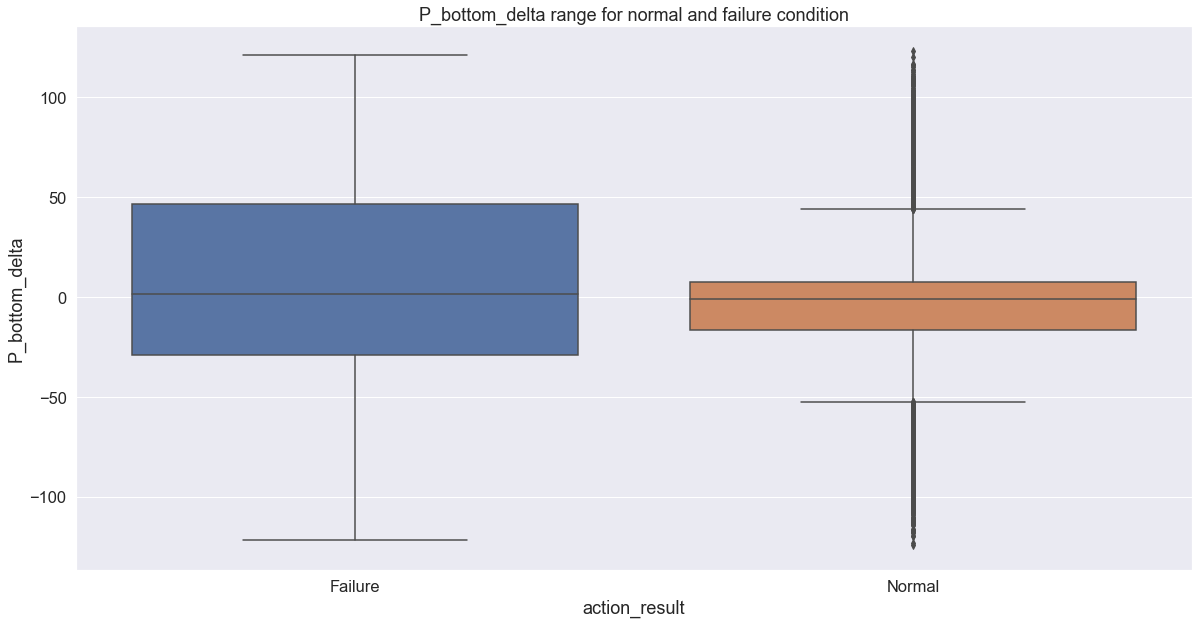

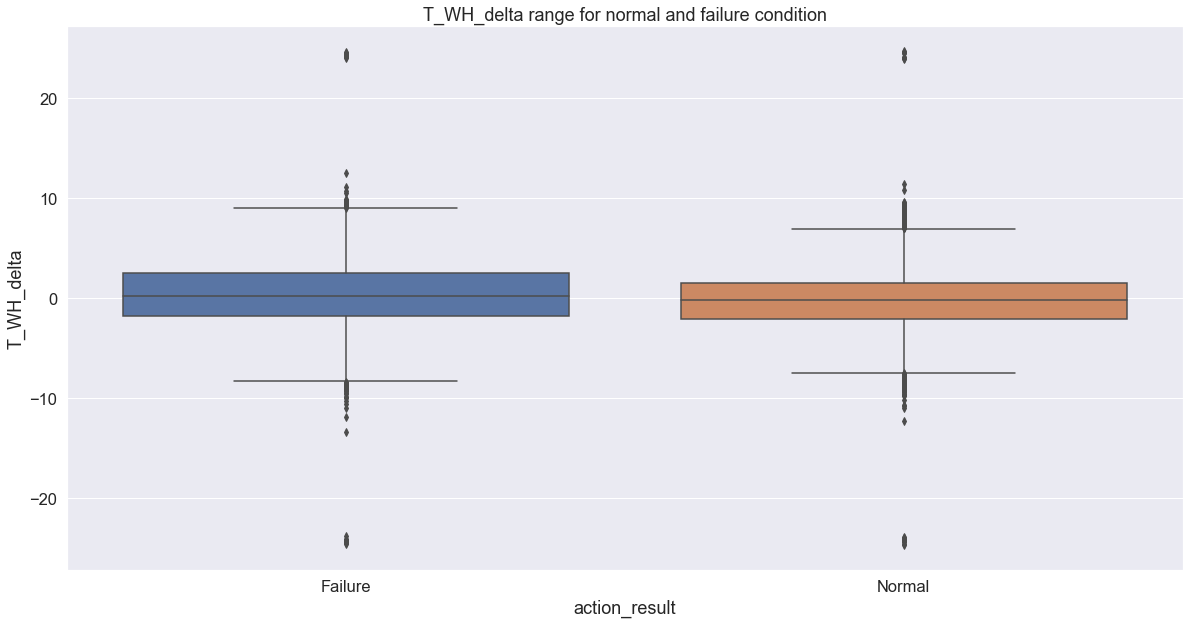

In [12]:
for var in [col for col in sim_results.columns if sim_results[col].dtype=='float64']:
    plt.figure()
    ax = sns.boxplot(x='action_result',
                 y=var,
                 data=sim_results).set(title=f'{var} range for normal and failure condition')

# Problem
## In a synthetic ICV failure dataset, is it possible to classifiy normal and failure data, based on the simulation data?

### Data cleaning

In [13]:
sim_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   P_Z0_before               10000 non-null  float64
 1   P_Z0_after                10000 non-null  float64
 2   P_Z1_before               10000 non-null  float64
 3   P_Z1_after                10000 non-null  float64
 4   P_WH_before               10000 non-null  float64
 5   P_WH_after                10000 non-null  float64
 6   T_Z0_before               10000 non-null  float64
 7   T_Z0_after                10000 non-null  float64
 8   T_Z1_before               10000 non-null  float64
 9   T_Z1_after                10000 non-null  float64
 10  top_icv_status_before     10000 non-null  bool   
 11  top_icv_status_after      10000 non-null  bool   
 12  bottom_icv_status_before  10000 non-null  bool   
 13  bottom_icv_status_after   10000 non-null  bool   
 14  P_botto

In [14]:
# Scikit-learn algorithms expect numeric features. So, string features need to be encoded before inserted into the model.
dic_encoders = {'action_result': LabelEncoder(),
               'command_type': OneHotEncoder(sparse=False)}

In [15]:
dic_encoders

{'action_result': LabelEncoder(), 'command_type': OneHotEncoder(sparse=False)}

In [16]:
dic_encoders['action_result'].fit(sim_results['action_result'])
new_col = dic_encoders['action_result'].transform(sim_results['action_result'])
new_col

array([0, 1, 1, ..., 0, 0, 1])

In [17]:
sim_results['action_result'] = new_col
sim_results

,P_Z0_before,P_Z0_after,P_Z1_before,P_Z1_after,P_WH_before,P_WH_after,T_Z0_before,T_Z0_after,T_Z1_before,T_Z1_after,...,T_WH_after,command_type,action_result,T_Z1_delta,T_Z0_delta,P_Z1_delta,P_Z0_delta,P_WH_delta,P_bottom_delta,T_WH_delta
0,782.991774,781.513238,721.997335,732.645404,228.072793,222.739237,88.990443,88.017064,88.256267,91.844784,...,72.954653,Close_Bottom,0,3.588516,-0.973379,10.648068,-1.478536,-5.333556,-69.947280,1.747713
1,823.407968,836.298427,785.214298,786.737540,114.380874,109.468553,85.859813,88.941707,90.356803,87.281548,...,82.429775,Open_Bottom,1,-3.075255,3.081894,1.523242,12.890459,-4.912321,101.261721,-0.041565
2,783.162356,781.606394,727.905276,727.690796,224.554990,230.421390,89.138396,88.773388,89.711909,88.672596,...,71.329930,No-action,1,-1.039313,-0.365007,-0.214480,-1.555962,5.866400,-0.852047,-1.229892
3,782.434641,799.091495,725.812266,725.502688,217.380665,222.701668,88.840552,89.561738,88.047662,87.951192,...,68.481609,Close_Bottom,0,-0.096470,0.721186,-0.309578,16.656854,5.321003,-75.381007,-3.491265
4,845.024456,830.298714,778.727926,791.655508,105.516327,111.314215,85.680819,86.664650,89.330981,86.211135,...,78.978201,No-action,1,-3.119846,0.983832,12.927583,-14.725742,5.797888,11.028805,-2.603948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,787.271113,781.998460,710.195918,716.790706,227.571746,222.070860,88.276114,86.481481,88.353872,88.491776,...,64.813454,Close_Top,0,0.137904,-1.794632,6.594787,-5.272653,-5.500886,-45.014137,-5.753539
9996,810.406086,794.551916,752.353625,750.208143,228.402031,224.036259,88.164860,87.298385,88.116074,90.366115,...,73.542945,Open_Top,0,2.250041,-0.866476,-2.145482,-15.854170,-4.365773,37.107424,5.332383
9997,787.086793,785.018482,732.677958,722.580568,223.745255,226.726036,89.784324,87.503559,89.757217,89.826107,...,71.450532,Close_Bottom,0,0.068890,-2.280765,-10.097390,-2.068311,2.980780,-4.265735,-1.839192
9998,850.027606,845.226598,774.510375,793.817333,115.348739,110.382150,87.331351,89.311389,84.625393,85.116316,...,78.105941,Close_Bottom,0,0.490923,1.980038,19.306958,-4.801008,-4.966590,-101.104098,-1.986409


In [18]:
new_cols = dic_encoders['command_type'].fit_transform(sim_results['command_type'].values.reshape(-1, 1)).T

In [19]:
new_cols.shape

(5, 10000)

In [20]:
for k in range(new_cols.shape[0]):
    sim_results[f'command_type_{k}'] = new_cols[k]
sim_results.drop(columns=['command_type'], inplace=True)

In [21]:
sim_results

,P_Z0_before,P_Z0_after,P_Z1_before,P_Z1_after,P_WH_before,P_WH_after,T_Z0_before,T_Z0_after,T_Z1_before,T_Z1_after,...,P_Z1_delta,P_Z0_delta,P_WH_delta,P_bottom_delta,T_WH_delta,command_type_0,command_type_1,command_type_2,command_type_3,command_type_4
0,782.991774,781.513238,721.997335,732.645404,228.072793,222.739237,88.990443,88.017064,88.256267,91.844784,...,10.648068,-1.478536,-5.333556,-69.947280,1.747713,1.0,0.0,0.0,0.0,0.0
1,823.407968,836.298427,785.214298,786.737540,114.380874,109.468553,85.859813,88.941707,90.356803,87.281548,...,1.523242,12.890459,-4.912321,101.261721,-0.041565,0.0,0.0,0.0,1.0,0.0
2,783.162356,781.606394,727.905276,727.690796,224.554990,230.421390,89.138396,88.773388,89.711909,88.672596,...,-0.214480,-1.555962,5.866400,-0.852047,-1.229892,0.0,0.0,1.0,0.0,0.0
3,782.434641,799.091495,725.812266,725.502688,217.380665,222.701668,88.840552,89.561738,88.047662,87.951192,...,-0.309578,16.656854,5.321003,-75.381007,-3.491265,1.0,0.0,0.0,0.0,0.0
4,845.024456,830.298714,778.727926,791.655508,105.516327,111.314215,85.680819,86.664650,89.330981,86.211135,...,12.927583,-14.725742,5.797888,11.028805,-2.603948,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,787.271113,781.998460,710.195918,716.790706,227.571746,222.070860,88.276114,86.481481,88.353872,88.491776,...,6.594787,-5.272653,-5.500886,-45.014137,-5.753539,0.0,1.0,0.0,0.0,0.0
9996,810.406086,794.551916,752.353625,750.208143,228.402031,224.036259,88.164860,87.298385,88.116074,90.366115,...,-2.145482,-15.854170,-4.365773,37.107424,5.332383,0.0,0.0,0.0,0.0,1.0
9997,787.086793,785.018482,732.677958,722.580568,223.745255,226.726036,89.784324,87.503559,89.757217,89.826107,...,-10.097390,-2.068311,2.980780,-4.265735,-1.839192,1.0,0.0,0.0,0.0,0.0
9998,850.027606,845.226598,774.510375,793.817333,115.348739,110.382150,87.331351,89.311389,84.625393,85.116316,...,19.306958,-4.801008,-4.966590,-101.104098,-1.986409,1.0,0.0,0.0,0.0,0.0


In [22]:
dic_encoders

{'action_result': LabelEncoder(), 'command_type': OneHotEncoder(sparse=False)}

In [23]:
joblib.dump(dic_encoders, '../outputs/models/dic_enconders_half-open.pkl')

['../outputs/models/dic_enconders_half-open.pkl']

In [24]:
sim_results

,P_Z0_before,P_Z0_after,P_Z1_before,P_Z1_after,P_WH_before,P_WH_after,T_Z0_before,T_Z0_after,T_Z1_before,T_Z1_after,...,P_Z1_delta,P_Z0_delta,P_WH_delta,P_bottom_delta,T_WH_delta,command_type_0,command_type_1,command_type_2,command_type_3,command_type_4
0,782.991774,781.513238,721.997335,732.645404,228.072793,222.739237,88.990443,88.017064,88.256267,91.844784,...,10.648068,-1.478536,-5.333556,-69.947280,1.747713,1.0,0.0,0.0,0.0,0.0
1,823.407968,836.298427,785.214298,786.737540,114.380874,109.468553,85.859813,88.941707,90.356803,87.281548,...,1.523242,12.890459,-4.912321,101.261721,-0.041565,0.0,0.0,0.0,1.0,0.0
2,783.162356,781.606394,727.905276,727.690796,224.554990,230.421390,89.138396,88.773388,89.711909,88.672596,...,-0.214480,-1.555962,5.866400,-0.852047,-1.229892,0.0,0.0,1.0,0.0,0.0
3,782.434641,799.091495,725.812266,725.502688,217.380665,222.701668,88.840552,89.561738,88.047662,87.951192,...,-0.309578,16.656854,5.321003,-75.381007,-3.491265,1.0,0.0,0.0,0.0,0.0
4,845.024456,830.298714,778.727926,791.655508,105.516327,111.314215,85.680819,86.664650,89.330981,86.211135,...,12.927583,-14.725742,5.797888,11.028805,-2.603948,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,787.271113,781.998460,710.195918,716.790706,227.571746,222.070860,88.276114,86.481481,88.353872,88.491776,...,6.594787,-5.272653,-5.500886,-45.014137,-5.753539,0.0,1.0,0.0,0.0,0.0
9996,810.406086,794.551916,752.353625,750.208143,228.402031,224.036259,88.164860,87.298385,88.116074,90.366115,...,-2.145482,-15.854170,-4.365773,37.107424,5.332383,0.0,0.0,0.0,0.0,1.0
9997,787.086793,785.018482,732.677958,722.580568,223.745255,226.726036,89.784324,87.503559,89.757217,89.826107,...,-10.097390,-2.068311,2.980780,-4.265735,-1.839192,1.0,0.0,0.0,0.0,0.0
9998,850.027606,845.226598,774.510375,793.817333,115.348739,110.382150,87.331351,89.311389,84.625393,85.116316,...,19.306958,-4.801008,-4.966590,-101.104098,-1.986409,1.0,0.0,0.0,0.0,0.0


In [25]:
# Saving to compare to the test dataset
joblib.dump(sim_results, '../outputs/models/train_data.pkl')

['../outputs/models/train_data.pkl']

### Splitting input (X) and output (y) data:
Output: action_result

In [26]:
y = sim_results['action_result']
X = sim_results.drop(columns='action_result')

In [27]:
X

,P_Z0_before,P_Z0_after,P_Z1_before,P_Z1_after,P_WH_before,P_WH_after,T_Z0_before,T_Z0_after,T_Z1_before,T_Z1_after,...,P_Z1_delta,P_Z0_delta,P_WH_delta,P_bottom_delta,T_WH_delta,command_type_0,command_type_1,command_type_2,command_type_3,command_type_4
0,782.991774,781.513238,721.997335,732.645404,228.072793,222.739237,88.990443,88.017064,88.256267,91.844784,...,10.648068,-1.478536,-5.333556,-69.947280,1.747713,1.0,0.0,0.0,0.0,0.0
1,823.407968,836.298427,785.214298,786.737540,114.380874,109.468553,85.859813,88.941707,90.356803,87.281548,...,1.523242,12.890459,-4.912321,101.261721,-0.041565,0.0,0.0,0.0,1.0,0.0
2,783.162356,781.606394,727.905276,727.690796,224.554990,230.421390,89.138396,88.773388,89.711909,88.672596,...,-0.214480,-1.555962,5.866400,-0.852047,-1.229892,0.0,0.0,1.0,0.0,0.0
3,782.434641,799.091495,725.812266,725.502688,217.380665,222.701668,88.840552,89.561738,88.047662,87.951192,...,-0.309578,16.656854,5.321003,-75.381007,-3.491265,1.0,0.0,0.0,0.0,0.0
4,845.024456,830.298714,778.727926,791.655508,105.516327,111.314215,85.680819,86.664650,89.330981,86.211135,...,12.927583,-14.725742,5.797888,11.028805,-2.603948,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,787.271113,781.998460,710.195918,716.790706,227.571746,222.070860,88.276114,86.481481,88.353872,88.491776,...,6.594787,-5.272653,-5.500886,-45.014137,-5.753539,0.0,1.0,0.0,0.0,0.0
9996,810.406086,794.551916,752.353625,750.208143,228.402031,224.036259,88.164860,87.298385,88.116074,90.366115,...,-2.145482,-15.854170,-4.365773,37.107424,5.332383,0.0,0.0,0.0,0.0,1.0
9997,787.086793,785.018482,732.677958,722.580568,223.745255,226.726036,89.784324,87.503559,89.757217,89.826107,...,-10.097390,-2.068311,2.980780,-4.265735,-1.839192,1.0,0.0,0.0,0.0,0.0
9998,850.027606,845.226598,774.510375,793.817333,115.348739,110.382150,87.331351,89.311389,84.625393,85.116316,...,19.306958,-4.801008,-4.966590,-101.104098,-1.986409,1.0,0.0,0.0,0.0,0.0


In [28]:
y

0       0
1       1
2       1
3       0
4       1
       ..
9995    0
9996    0
9997    0
9998    0
9999    1
Name: action_result, Length: 10000, dtype: int32

In [29]:
models = {'Logistic_Reg_clf': LogisticRegression(random_state=42),
          'DT_clf': DecisionTreeClassifier(random_state=42),
          'RF_clf': RandomForestClassifier(random_state=42),
          'KNN_clf': KNeighborsClassifier(),
          'NB_clf': GaussianNB(),
          'SV_clf': SVC(random_state=42),
          'Adaboost_clf': AdaBoostClassifier(random_state=42),
          'XGBoost_RF_clf': XGBRFClassifier(random_state=42),
          'MLP_clf': MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42)
         }

In [30]:
for mod in models:
        
    print(f'Fitting model {mod}...')
    models[mod].fit(X, y)
    
    print('Done!')
    
    print('#################################################################')

Fitting model Logistic_Reg_clf...
Done!
#################################################################
Fitting model DT_clf...
Done!
#################################################################
Fitting model RF_clf...
Done!
#################################################################
Fitting model KNN_clf...
Done!
#################################################################
Fitting model NB_clf...
Done!
#################################################################
Fitting model SV_clf...
Done!
#################################################################
Fitting model Adaboost_clf...
Done!
#################################################################
Fitting model XGBoost_RF_clf...
Done!
#################################################################
Fitting model MLP_clf...
Done!
#################################################################


In [31]:
models

{'Logistic_Reg_clf': LogisticRegression(random_state=42),
 'DT_clf': DecisionTreeClassifier(random_state=42),
 'RF_clf': RandomForestClassifier(random_state=42),
 'KNN_clf': KNeighborsClassifier(),
 'NB_clf': GaussianNB(),
 'SV_clf': SVC(random_state=42),
 'Adaboost_clf': AdaBoostClassifier(random_state=42),
 'XGBoost_RF_clf': XGBRFClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                 colsample_bylevel=1, colsample_bytree=1,
                 early_stopping_rounds=None, enable_categorical=False,
                 eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
                 importance_type=None, interaction_constraints='', max_bin=256,
                 max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
                 max_leaves=0, min_child_weight=1, missing=nan,
                 monotone_constraints='()', n_estimators=100, n_jobs=0,
                 num_parallel_tree=100, objective='binary:logistic',
                 predictor='auto', random_

In [32]:
joblib.dump(models, '../outputs/models/models_half-open.pkl')

['../outputs/models/models_half-open.pkl']